<a href="https://colab.research.google.com/github/zjzsu2000/CMPE297_AdvanceDL_Project/blob/main/Data_Preprocessing/Final_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, LSTM, Bidirectional, Input, Concatenate
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [35]:
option = pd.read_csv('/gdrive/My Drive/Data set/Option/WIX_call-options-black-scholes.csv')
lstm_option = pd.read_csv('/gdrive/My Drive/Data set/Option/underlying/call/WIX_underlying_call.csv')
model_lstm = load_model('/gdrive/Shareddrives/CMPE297_49_project/models/model1_lstm_call_1.h5')
model2 = load_model('/gdrive/Shareddrives/CMPE297_49_project/models/model2_call21_all_4000.h5')
model3= load_model('/gdrive/Shareddrives/CMPE297_49_project/models/model3_call_sigma5_all_1024_4000.h5')

In [37]:
lstm_option.tail()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,UnderlyingSymbol,UnderlyingPrice,Exchange,OptionSymbol,Blank,Expiration,DataDate,Strike,Last,Bid,Ask,Volume,OpenInterest,IV,Delta,Gamma,Theta,Vega,Alias,sigma_5,sigma_10,sigma_21,sigma_30,date_diff,treasury_rate,black_scholes_pred_21,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
51487,51487,103562,103562,WIX,148.52,*,WIX210115C00185000,NaN,01/15/2021,7/31/2019 04:00:00 PM,185.0,0.00,16.4,19.2,0.0,0.0,0.4199,0.4462,0.5241,-2.9859,71.0047,NaN,0.053055,0.037583,0.02923,0.027146,534,2.0,3.659971e-08,30.45,33.87,33.48,34.02,33.67,34.11,33.49,32.85,32.51,33.0,33.6,33.85,34.39,33.21,33.06,33.79,33.15,32.04,31.5,31.19,31.24
51488,51488,103564,103564,WIX,148.52,*,WIX210115C00190000,NaN,01/15/2021,7/31/2019 04:00:00 PM,190.0,15.33,15.0,17.8,0.0,4.0,0.4175,0.4239,0.5223,-2.9365,70.3513,NaN,0.053055,0.037583,0.02923,0.027146,534,2.0,3.771637e-10,30.45,33.87,33.48,34.02,33.67,34.11,33.49,32.85,32.51,33.0,33.6,33.85,34.39,33.21,33.06,33.79,33.15,32.04,31.5,31.19,31.24
51489,51489,103566,103566,WIX,148.52,*,WIX210115C00195000,NaN,01/15/2021,7/31/2019 04:00:00 PM,195.0,13.40,13.9,16.4,0.0,1.0,0.4139,0.4014,0.5201,-2.8700,69.4568,NaN,0.053055,0.037583,0.02923,0.027146,534,2.0,2.594149e-12,30.45,33.87,33.48,34.02,33.67,34.11,33.49,32.85,32.51,33.0,33.6,33.85,34.39,33.21,33.06,33.79,33.15,32.04,31.5,31.19,31.24
51490,51490,103568,103568,WIX,148.52,*,WIX210115C00200000,NaN,01/15/2021,7/31/2019 04:00:00 PM,200.0,11.80,12.9,15.2,0.0,16.0,0.4120,0.3805,0.5147,-2.8101,68.4214,NaN,0.053055,0.037583,0.02923,0.027146,534,2.0,1.226700e-14,30.45,33.87,33.48,34.02,33.67,34.11,33.49,32.85,32.51,33.0,33.6,33.85,34.39,33.21,33.06,33.79,33.15,32.04,31.5,31.19,31.24
51491,51491,103570,103570,WIX,148.52,*,WIX210115C00210000,NaN,01/15/2021,7/31/2019 04:00:00 PM,210.0,12.00,10.1,13.2,2.0,38.0,0.4110,0.3430,0.4980,-2.6967,66.0350,NaN,0.053055,0.037583,0.02923,0.027146,534,2.0,9.948072e-20,30.45,33.87,33.48,34.02,33.67,34.11,33.49,32.85,32.51,33.0,33.6,33.85,34.39,33.21,33.06,33.79,33.15,32.04,31.5,31.19,31.24


In [38]:
model_lstm.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 21, 1)]      0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 8)            1952        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 12)           0           sequential_1[0][0]               
                                                                 input_4[0][0]         

In [39]:
lstm_test = lstm_option[lstm_option['OptionSymbol']=='WIX200117C00060000']

In [40]:
lstm_test

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,UnderlyingSymbol,UnderlyingPrice,Exchange,OptionSymbol,Blank,Expiration,DataDate,Strike,Last,Bid,Ask,Volume,OpenInterest,IV,Delta,Gamma,Theta,Vega,Alias,sigma_5,sigma_10,sigma_21,sigma_30,date_diff,treasury_rate,black_scholes_pred_21,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
75,75,150,150,WIX,57.95,*,WIX200117C00060000,NaN,01/17/2020,1/2/2018 04:00:00 PM,60.0,14.20,13.7,17.8,0.0,6.0,0.5721,0.6452,0.7858,-1.1968,30.8156,NaN,NaN,NaN,NaN,NaN,745,1.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,159,318,318,WIX,58.30,*,WIX200117C00060000,NaN,01/17/2020,1/3/2018 04:00:00 PM,60.0,14.20,14.2,16.9,0.0,6.0,0.5363,0.6376,0.8401,-1.1388,31.2121,NaN,NaN,NaN,NaN,NaN,744,1.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,243,486,486,WIX,62.10,*,WIX200117C00060000,NaN,01/17/2020,1/4/2018 04:00:00 PM,60.0,14.20,16.2,20.3,0.0,6.0,0.5653,0.6744,0.7191,-1.2287,31.9109,NaN,NaN,NaN,NaN,NaN,743,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,327,654,654,WIX,60.65,*,WIX200117C00060000,NaN,01/17/2020,1/5/2018 04:00:00 PM,60.0,14.20,15.8,17.9,0.0,6.0,0.5206,0.6527,0.8204,-1.1355,31.9402,NaN,NaN,NaN,NaN,NaN,742,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,411,822,822,WIX,61.05,*,WIX200117C00060000,NaN,01/17/2020,1/8/2018 04:00:00 PM,60.0,14.20,15.4,18.4,0.0,6.0,0.5292,0.6577,0.7991,-1.1574,31.9105,NaN,0.033379,NaN,NaN,NaN,739,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50772,50772,102132,102132,WIX,145.47,*,WIX200117C00060000,NaN,01/17/2020,7/25/2019 04:00:00 PM,60.0,86.04,84.3,88.4,0.0,32.0,0.9604,0.9528,0.1016,-2.9216,9.9435,NaN,0.015078,0.019606,0.018441,0.022449,176,2.08,86.068768,33.67,34.11,33.49,32.85,32.51,33.00,33.60,33.85,34.39,33.21,33.06,33.79,33.15,32.04,31.50,31.19,31.24,31.20,30.37,30.74,29.92
50931,50931,102450,102450,WIX,149.14,*,WIX200117C00060000,NaN,01/17/2020,7/26/2019 04:00:00 PM,60.0,86.04,87.7,91.8,0.0,32.0,0.9524,0.9574,0.0922,-2.7565,9.3524,NaN,0.015076,0.015556,0.017786,0.021421,175,2.10,89.741079,34.02,33.67,34.11,33.49,32.85,32.51,33.00,33.60,33.85,34.39,33.21,33.06,33.79,33.15,32.04,31.50,31.19,31.24,31.20,30.37,30.74
51090,51090,102768,102768,WIX,147.42,*,WIX200117C00060000,NaN,01/17/2020,7/29/2019 04:00:00 PM,60.0,86.04,85.7,89.8,0.0,32.0,0.9224,0.9598,0.0928,-2.5631,8.7597,NaN,0.017021,0.015576,0.018002,0.020211,172,2.10,88.010825,33.48,34.02,33.67,34.11,33.49,32.85,32.51,33.00,33.60,33.85,34.39,33.21,33.06,33.79,33.15,32.04,31.50,31.19,31.24,31.20,30.37
51249,51249,103086,103086,WIX,148.01,*,WIX200117C00060000,NaN,01/17/2020,7/30/2019 04:00:00 PM,60.0,86.04,86.2,90.5,0.0,32.0,0.9405,0.9587,0.0928,-2.6758,8.9544,NaN,0.014728,0.015906,0.017308,0.018911,171,2.07,88.589056,33.87,33.48,34.02,33.67,34.11,33.49,32.85,32.51,33.00,33.60,33.85,34.39,33.21,33.06,33.79,33.15,32.04,31.50,31.19,31.24,31.20


In [41]:
lstm_test = lstm_test[['UnderlyingPrice','Strike','Bid','Ask','sigma_21','date_diff','treasury_rate','1','2','3','4','5','6','7','8','9','10'
                      ,'11','12','13','14','15','16','17','18','19','20','21']]

In [42]:
lstm_test = lstm_test.dropna()

In [43]:
lstm_test

,UnderlyingPrice,Strike,Bid,Ask,sigma_21,date_diff,treasury_rate,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
1731,61.05,60.0,16.2,18.4,0.029875,716,2.14,13.735,12.865,13.320,12.950,12.410,12.710,12.94,12.64,12.59,12.47,12.18,11.91,12.02,12.1404,11.9600,11.8200,12.2800,11.8800,12.12,11.55,10.98
1812,61.75,60.0,16.7,18.7,0.030058,715,2.16,13.250,13.735,12.865,13.320,12.950,12.410,12.71,12.94,12.64,12.59,12.47,12.18,11.91,12.0200,12.1404,11.9600,11.8200,12.2800,11.88,12.12,11.55
1893,61.45,60.0,16.3,18.3,0.031937,714,2.15,12.450,13.250,13.735,12.865,13.320,12.950,12.41,12.71,12.94,12.64,12.59,12.47,12.18,11.9100,12.0200,12.1404,11.9600,11.8200,12.28,11.88,12.12
1974,60.00,60.0,15.5,18.8,0.035571,711,2.08,11.570,12.450,13.250,13.735,12.865,13.320,12.95,12.41,12.71,12.94,12.64,12.59,12.47,12.1800,11.9100,12.0200,12.1404,11.9600,11.82,12.28,11.88
2055,60.15,60.0,15.6,17.6,0.034691,710,2.10,11.640,11.570,12.450,13.250,13.735,12.865,13.32,12.95,12.41,12.71,12.94,12.64,12.59,12.4700,12.1800,11.9100,12.0200,12.1404,11.96,11.82,12.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50772,145.47,60.0,84.3,88.4,0.018441,176,2.08,33.670,34.110,33.490,32.850,32.510,33.000,33.60,33.85,34.39,33.21,33.06,33.79,33.15,32.0400,31.5000,31.1900,31.2400,31.2000,30.37,30.74,29.92
50931,149.14,60.0,87.7,91.8,0.017786,175,2.10,34.020,33.670,34.110,33.490,32.850,32.510,33.00,33.60,33.85,34.39,33.21,33.06,33.79,33.1500,32.0400,31.5000,31.1900,31.2400,31.20,30.37,30.74
51090,147.42,60.0,85.7,89.8,0.018002,172,2.10,33.480,34.020,33.670,34.110,33.490,32.850,32.51,33.00,33.60,33.85,34.39,33.21,33.06,33.7900,33.1500,32.0400,31.5000,31.1900,31.24,31.20,30.37
51249,148.01,60.0,86.2,90.5,0.017308,171,2.07,33.870,33.480,34.020,33.670,34.110,33.490,32.85,32.51,33.00,33.60,33.85,34.39,33.21,33.0600,33.7900,33.1500,32.0400,31.5000,31.19,31.24,31.20


In [60]:
#test_lstm_f = lstm_test[['UnderlyingPrice','Strike','sigma_21','date_diff','treasury_rate']]
test_lstm_x = lstm_test.drop(['Bid','sigma_21','Ask'], axis=1).values
#[['1','2','3','4','5','6','7','8','9','10'
 #                     ,'11','12','13','14','15','16','17','18','19','20','21']]
test_lstm_y = (lstm_test.Bid + lstm_test.Ask) /2

In [61]:
N_TIMESTEPS = 21
test_lstm_x = [test_lstm_x[:, -N_TIMESTEPS:].reshape(test_lstm_x.shape[0], N_TIMESTEPS, 1), test_lstm_x[:, :4]]

In [71]:
test_lstm_x[1]

array([[ 61.05,  60.  , 716.  ,   2.14],
       [ 61.75,  60.  , 715.  ,   2.16],
       [ 61.45,  60.  , 714.  ,   2.15],
       ...,
       [147.42,  60.  , 172.  ,   2.1 ],
       [148.01,  60.  , 171.  ,   2.07],
       [148.52,  60.  , 170.  ,   2.1 ]])

In [72]:
model_lstm.evaluate([test_lstm_x,test_lstm_f],test_lstm_y,batch_size=1024)

1/1 [==============================] - 0s 1ms/step - loss: 1.7065


1.7064849138259888

In [73]:
lstmpre = model_lstm.predict(test_lstm_x)

In [75]:
test_lstm_y

1731     17.30
1812     17.70
1893     17.30
1974     17.15
2055     16.60
         ...  
50772    86.35
50931    89.75
51090    87.75
51249    88.35
51408    89.15
Length: 374, dtype: float64

In [74]:
lstmpre

array([[15.772799 ],
       [16.212334 ],
       [15.96381  ],
       [15.186068 ],
       [15.2308445],
       [15.061851 ],
       [14.120266 ],
       [15.0169735],
       [16.903349 ],
       [18.46055  ],
       [22.262005 ],
       [23.990486 ],
       [24.707445 ],
       [24.39081  ],
       [26.01874  ],
       [24.276548 ],
       [25.427788 ],
       [25.433115 ],
       [25.094542 ],
       [24.948423 ],
       [25.175402 ],
       [26.533628 ],
       [28.586279 ],
       [28.465364 ],
       [30.027071 ],
       [30.448084 ],
       [30.323631 ],
       [30.623362 ],
       [29.553125 ],
       [30.543219 ],
       [30.034325 ],
       [31.345766 ],
       [30.76657  ],
       [32.796726 ],
       [33.193893 ],
       [31.24243  ],
       [27.65693  ],
       [30.456163 ],
       [27.070303 ],
       [26.4388   ],
       [28.435308 ],
       [27.043798 ],
       [29.043543 ],
       [30.36672  ],
       [30.767962 ],
       [30.243486 ],
       [29.845243 ],
       [32.11

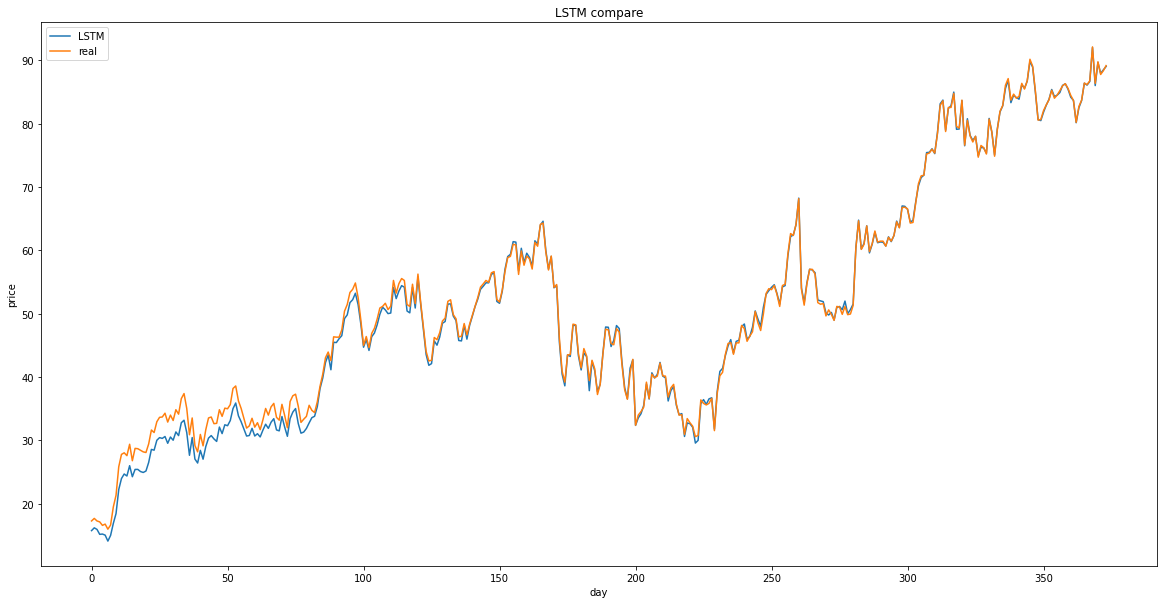

In [77]:
from matplotlib import pyplot as plt4
plt4.figure(figsize=(20, 10))
plt4.ylabel('price')
plt4.xlabel('day')
plt4.title('LSTM compare')
plt4.plot(lstmpre,label = 'LSTM')  
plt4.plot(test_lstm_y.values, label = 'real')
plt4.legend()

In [3]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               2400      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               1

In [4]:
option.head()

,Unnamed: 0,Unnamed: 0.1,UnderlyingSymbol,UnderlyingPrice,Exchange,OptionSymbol,Blank,Expiration,DataDate,Strike,Last,Bid,Ask,Volume,OpenInterest,IV,Delta,Gamma,Theta,Vega,Alias,sigma_5,sigma_10,sigma_21,sigma_30,date_diff,treasury_rate,black_scholes_pred_21
0,0,0,WIX,57.95,*,WIX180119C00040000,NaN,01/19/2018,1/2/2018 04:00:00 PM,40.0,17.90,17.00,20.30,0.0,12.0,2.0474,0.8556,0.8885,-17.1540,2.8402,NaN,NaN,NaN,NaN,NaN,17,1.29,NaN
1,2,2,WIX,57.95,*,WIX180119C00045000,NaN,01/19/2018,1/2/2018 04:00:00 PM,45.0,14.82,11.70,15.40,0.0,14.0,1.6263,0.8151,1.3130,-15.9985,3.3340,NaN,NaN,NaN,NaN,NaN,17,1.29,NaN
2,4,4,WIX,57.95,*,WIX180119C00050000,NaN,01/19/2018,1/2/2018 04:00:00 PM,50.0,9.20,7.70,9.60,0.0,24.0,0.9858,0.7884,2.3499,-10.5303,3.6168,NaN,NaN,NaN,NaN,NaN,17,1.29,NaN
3,6,6,WIX,57.95,*,WIX180119C00055000,NaN,01/19/2018,1/2/2018 04:00:00 PM,55.0,3.61,3.60,4.30,0.0,314.0,0.5262,0.6978,5.3048,-6.7828,4.3585,NaN,NaN,NaN,NaN,NaN,17,1.29,NaN
4,8,8,WIX,57.95,*,WIX180119C00060000,NaN,01/19/2018,1/2/2018 04:00:00 PM,60.0,1.45,1.15,1.65,181.0,726.0,0.5014,0.3950,6.1458,-7.1221,4.8110,NaN,NaN,NaN,NaN,NaN,17,1.29,NaN


In [5]:
option.OptionSymbol.value_counts()

WIX200117C00075000    394
WIX200117C00085000    394
WIX200117C00100000    394
WIX200117C00040000    394
WIX200117C00065000    394
                     ... 
WIX190920C00165000      8
WIX190920C00185000      8
WIX190920C00160000      8
WIX190920C00180000      8
WIX180316C00095000      5
Name: OptionSymbol, Length: 531, dtype: int64

In [6]:
test = option[option['OptionSymbol']=='WIX200117C00060000']

In [7]:
test = test[['UnderlyingPrice','Strike','Bid','Ask','sigma_21','date_diff','treasury_rate']]

In [8]:
test=test.dropna()

In [9]:
test

,UnderlyingPrice,Strike,Bid,Ask,sigma_21,date_diff,treasury_rate
1731,61.05,60.0,16.2,18.4,0.029875,716,2.14
1812,61.75,60.0,16.7,18.7,0.030058,715,2.16
1893,61.45,60.0,16.3,18.3,0.031937,714,2.15
1974,60.00,60.0,15.5,18.8,0.035571,711,2.08
2055,60.15,60.0,15.6,17.6,0.034691,710,2.10
...,...,...,...,...,...,...,...
50772,145.47,60.0,84.3,88.4,0.018441,176,2.08
50931,149.14,60.0,87.7,91.8,0.017786,175,2.10
51090,147.42,60.0,85.7,89.8,0.018002,172,2.10
51249,148.01,60.0,86.2,90.5,0.017308,171,2.07


In [10]:
test_x = test[['UnderlyingPrice','Strike','sigma_21','date_diff','treasury_rate']]
test_y = (test.Bid + test.Ask) /2

In [11]:
model2.evaluate(test_x,test_y,batch_size=1024)

1/1 [==============================] - 0s 2ms/step - loss: 0.9988


0.998781681060791

In [12]:
pred= model2.predict(test_x)

In [13]:
len(pred)

374

In [14]:
len(test_y)

374

In [15]:
test_y

1731     17.30
1812     17.70
1893     17.30
1974     17.15
2055     16.60
         ...  
50772    86.35
50931    89.75
51090    87.75
51249    88.35
51408    89.15
Length: 374, dtype: float64

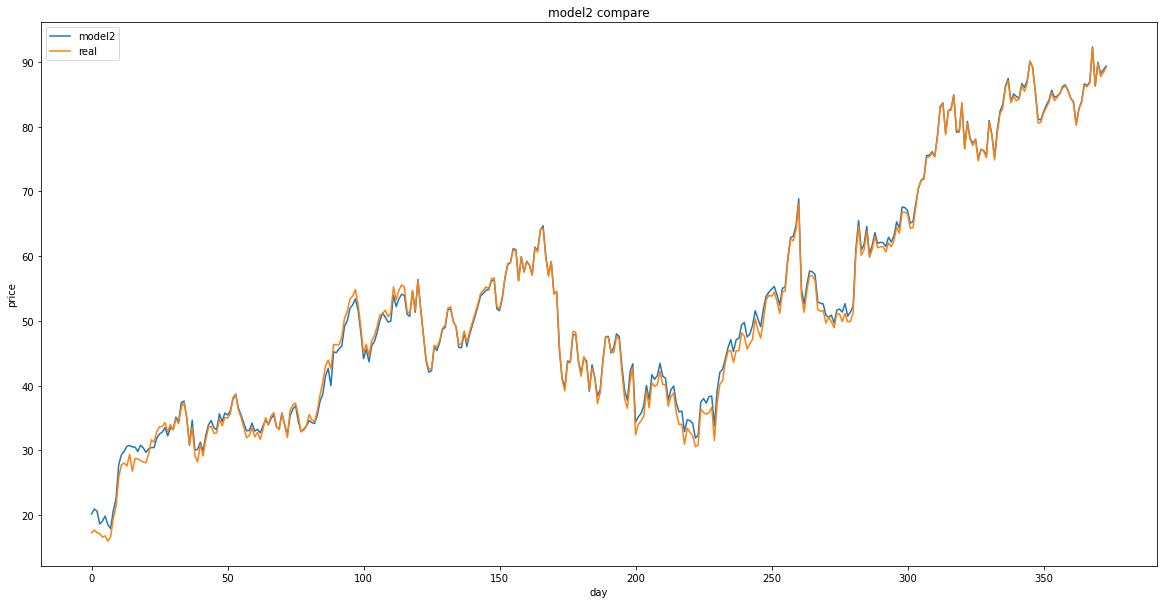

In [34]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 10))
plt.ylabel('price')
plt.xlabel('day')
plt.title('model2 compare')
plt.plot(pred,label = 'model2')  
plt.plot(test_y.values, label = 'real')
plt.legend()

In [16]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               2400      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               1

In [17]:
pre3=model3.predict(test_x)

In [28]:
len(pre3[:,0])

374

In [20]:
test_y3 = test[['Bid','Ask']]

In [24]:
test_yb = test_y3.Bid.values
test_ya = test_y3.Ask.values

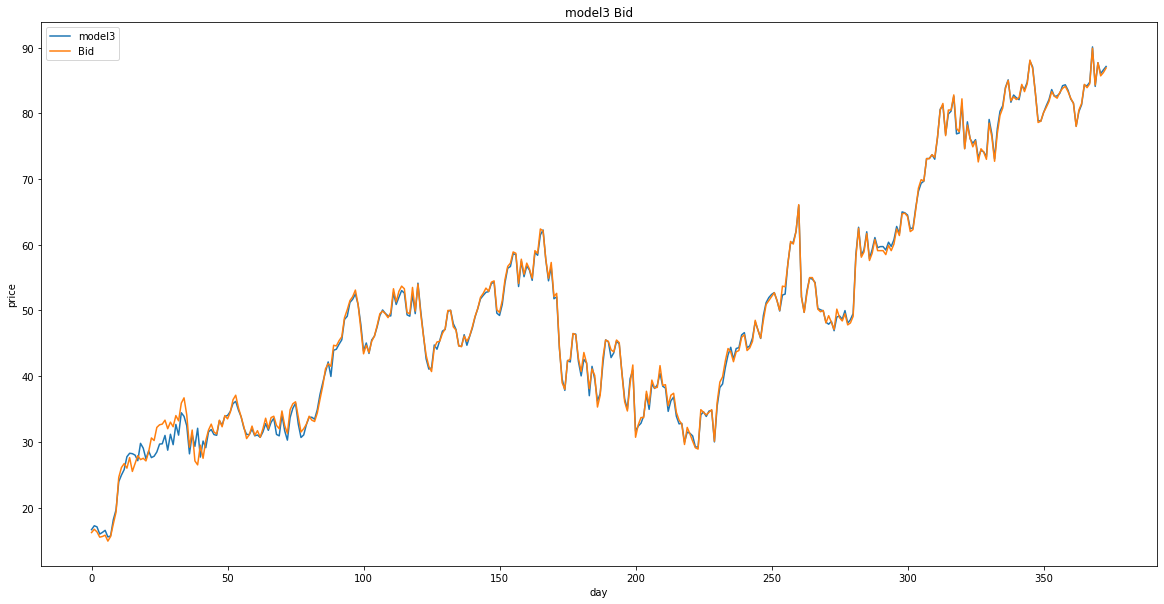

In [33]:
from matplotlib import pyplot as plt2
plt2.figure(figsize=(20, 10))
plt2.ylabel('price')
plt2.xlabel('day')
plt2.title('model3 Bid')
plt2.plot(pre3[:,0],label = 'model3') 
plt2.plot(test_yb, label = 'Bid')
plt2.legend() 

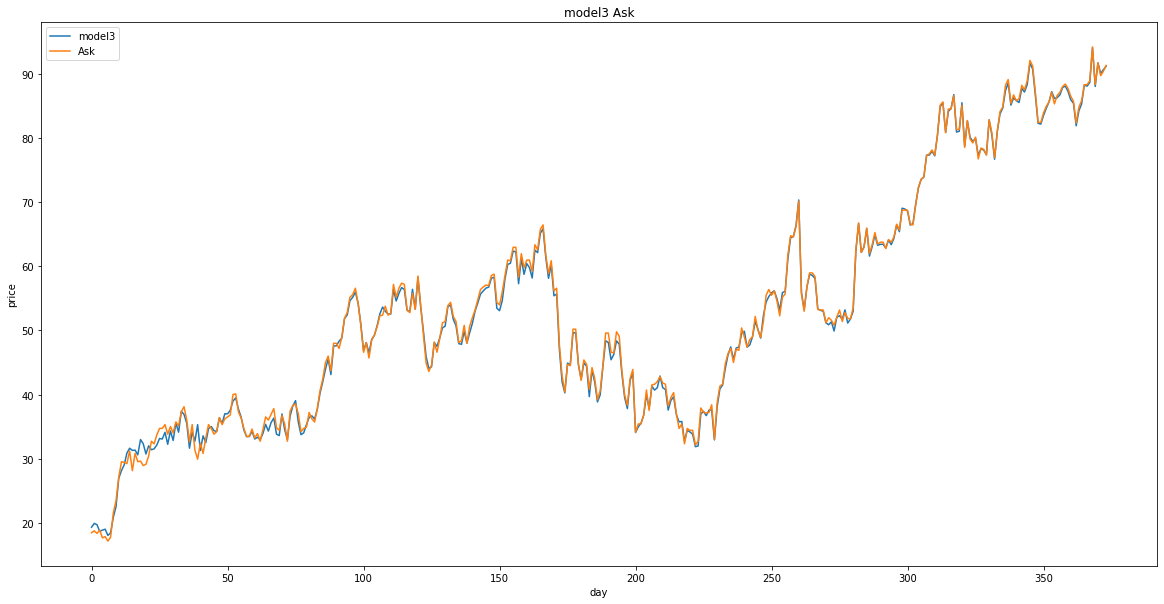

In [32]:
from matplotlib import pyplot as plt3
plt3.figure(figsize=(20, 10))
plt3.ylabel('price')
plt3.xlabel('day')
plt3.title('model3 Ask')
plt3.plot(pre3[:,1],label = 'model3') 
plt3.plot(test_ya, label = 'Ask')
plt3.legend() 